In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Настройка стилей
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# === ГЕНЕРАЦИЯ ДАННЫХ ===
np.random.seed(42)

# Генерация дат с января 2022 по апрель 2025
dates = pd.date_range(start='2022-01-01', end='2025-04-30', freq='M')

# Категории женской верхней одежды с их характеристиками
categories_info = {
    'Пальто': {'base_sales': 45, 'winter_boost': 2.0, 'summer_drop': 0.2},
    'Куртки': {'base_sales': 65, 'winter_boost': 1.8, 'summer_drop': 0.3},
    'Пуховики': {'base_sales': 55, 'winter_boost': 2.2, 'summer_drop': 0.1},
    'Плащи': {'base_sales': 35, 'winter_boost': 0.8, 'summer_drop': 0.6},
    'Жакеты': {'base_sales': 40, 'winter_boost': 1.1, 'summer_drop': 0.7}
}

n_skus = 150
categories = list(categories_info.keys())

# Генерация справочника артикулов
sku_catalog = pd.DataFrame({
    'sku': [f'SKU_{i:03d}' for i in range(1, n_skus+1)],
    'category': np.random.choice(categories, n_skus),
    'price': np.random.uniform(2000, 15000, n_skus)
})

# Генерация реалистичных данных продаж
def generate_seasonal_sales(date, category, base_sales):
    month = date.month
    
    # Определяем сезонные коэффициенты для каждой категории
    if month in [12, 1, 2]:  # Зима
        factor = categories_info[category]['winter_boost']
    elif month in [3, 4]:  # Ранняя весна
        factor = categories_info[category]['winter_boost'] * 0.7
    elif month in [5, 6]:  # Поздняя весна
        factor = 0.8
    elif month in [7, 8]:  # Лето
        factor = categories_info[category]['summer_drop']
    elif month in [9, 10]:  # Осень
        factor = 1.2
    else:  # Ноябрь - предзимье
        factor = categories_info[category]['winter_boost'] * 0.9
    
    # Добавляем трендовую составляющую (небольшой рост год к году)
    year_trend = 1 + (date.year - 2022) * 0.05
    
    # Генерируем продажи с учетом сезонности и тренда
    sales = np.random.poisson(base_sales * factor * year_trend)
    return max(0, sales)

# Создание данных по продажам
records = []
for date in dates:
    for _, row in sku_catalog.iterrows():
        base_sales = categories_info[row['category']]['base_sales']
        sales = generate_seasonal_sales(date, row['category'], base_sales)
        records.append({
            'date': date,
            'sku': row['sku'],
            'category': row['category'],
            'sales_units': sales,
            'sales_revenue': sales * row['price']
        })

sales_data = pd.DataFrame(records)

In [3]:
sales_data

,date,sku,category,sales_units,sales_revenue
0,2022-01-31,SKU_001,Плащи,24,159164.925480
1,2022-01-31,SKU_002,Жакеты,33,455029.401423
2,2022-01-31,SKU_003,Пуховики,125,692214.905250
3,2022-01-31,SKU_004,Жакеты,32,333439.090145
4,2022-01-31,SKU_005,Жакеты,43,86290.890740
...,...,...,...,...,...
5995,2025-04-30,SKU_146,Плащи,27,101954.087336
5996,2025-04-30,SKU_147,Плащи,20,224316.859197
5997,2025-04-30,SKU_148,Пуховики,96,881919.331181
5998,2025-04-30,SKU_149,Куртки,92,538626.131803


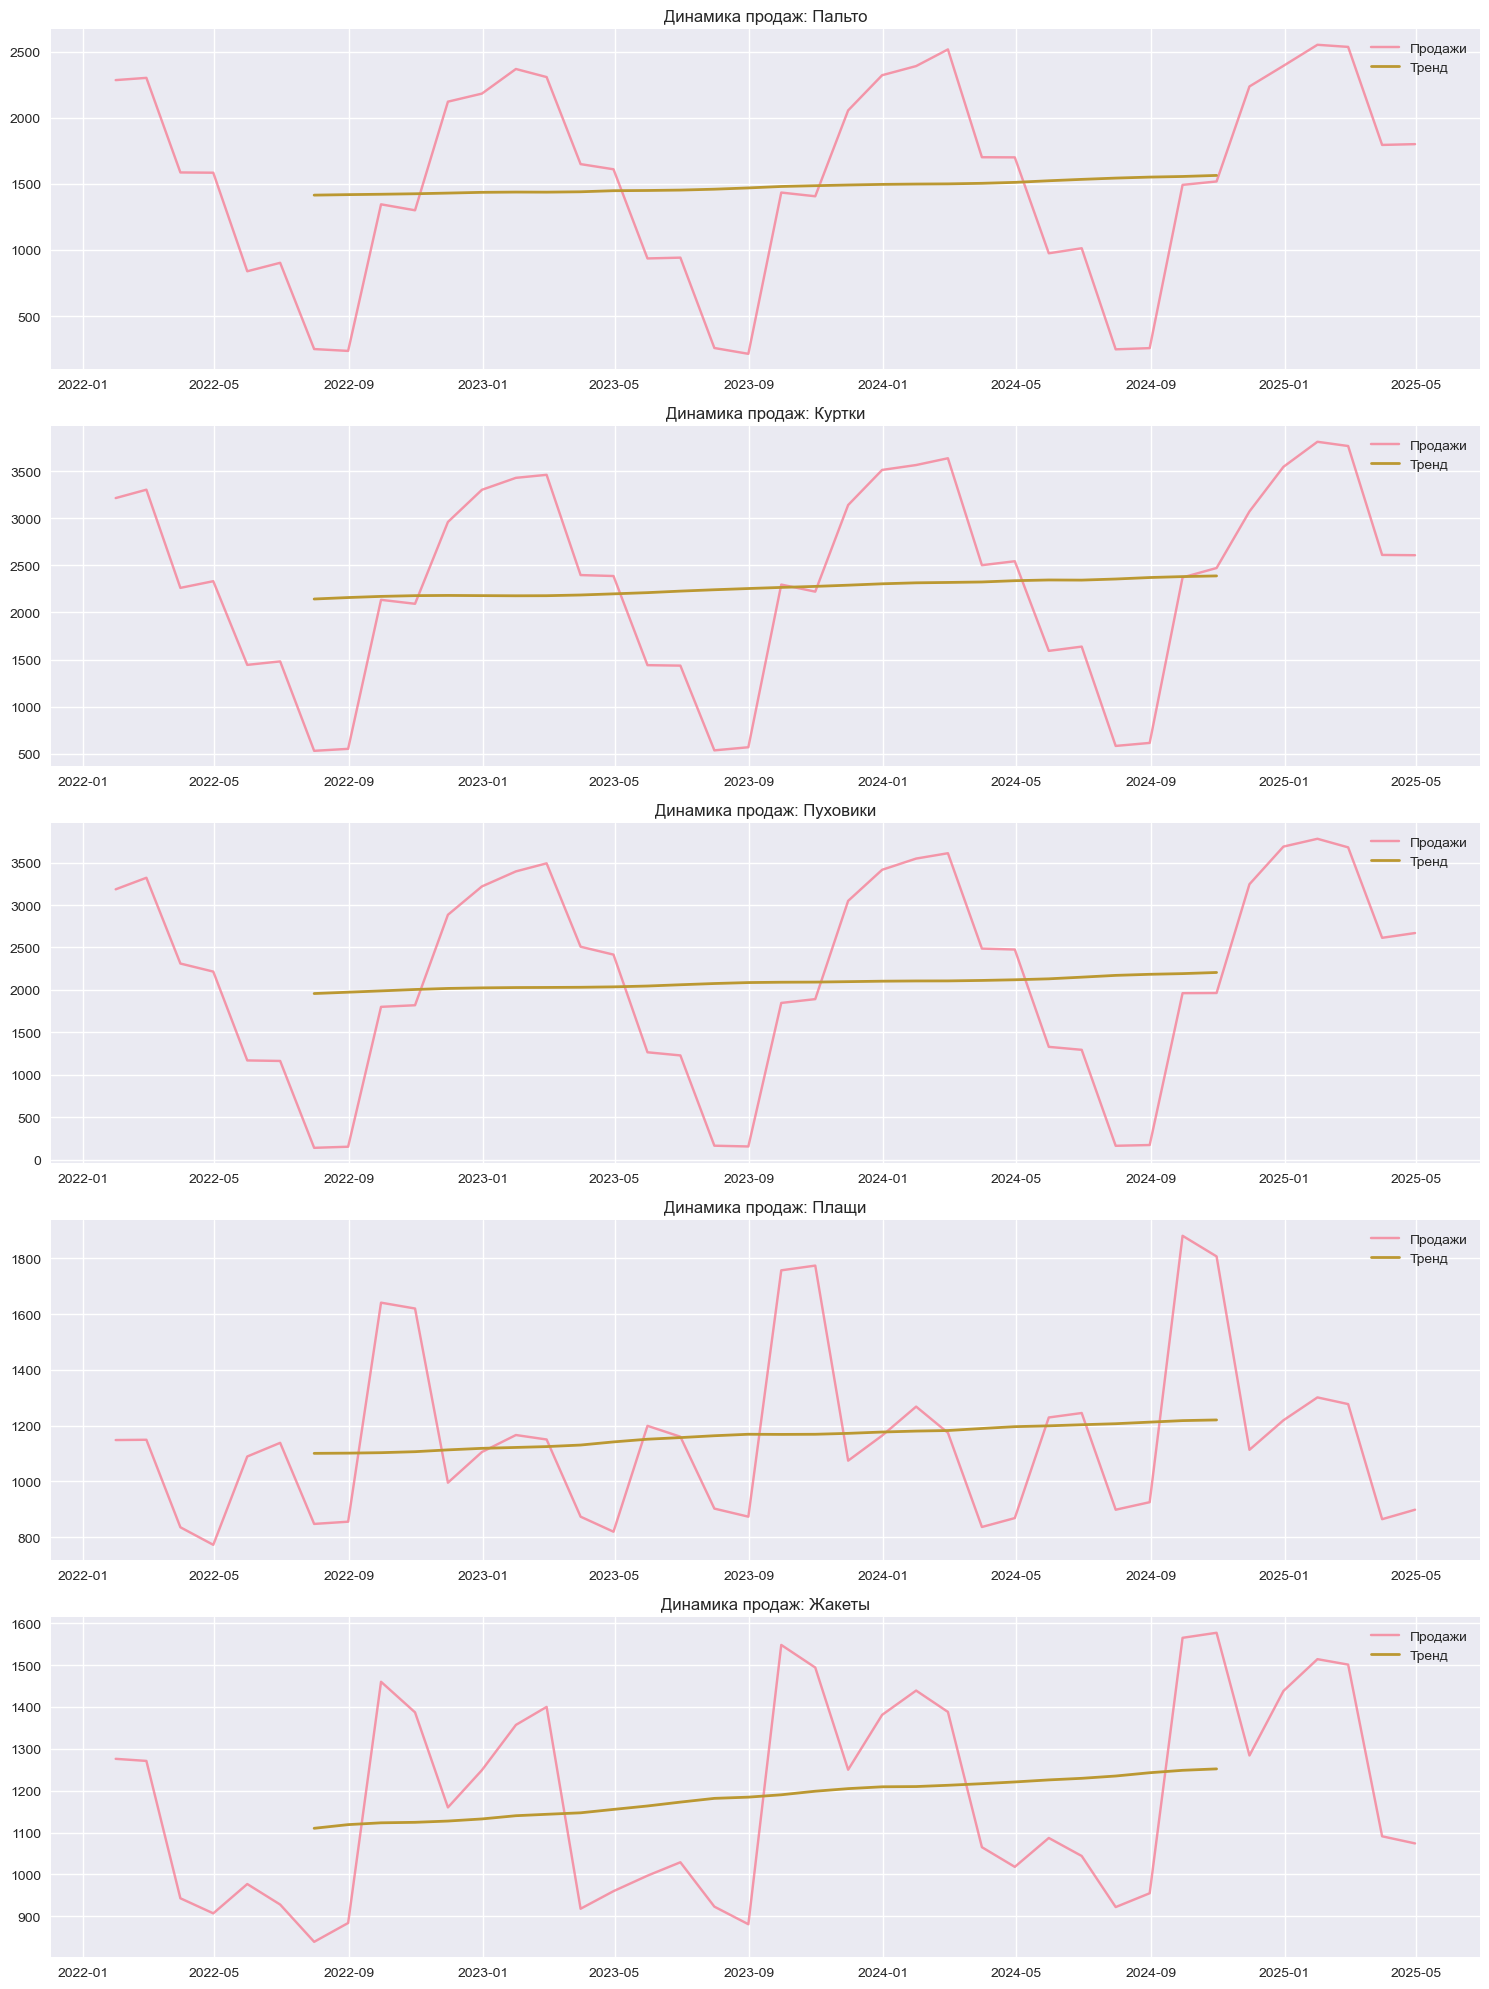

In [ ]:
category_seasonality = {}
category_decomposition = {}

fig, axes = plt.subplots(len(categories), 1, figsize=(15, 20))

for i, category in enumerate(categories):
    # Агрегируем данные по категории
    cat_data = sales_data[sales_data['category'] == category].groupby('date')['sales_units'].sum()
    
    # Разложение временного ряда
    decomposition = seasonal_decompose(cat_data, model='additive', period=12)
    category_decomposition[category] = decomposition
    
    # Извлекаем сезонные коэффициенты
    seasonal_pattern = decomposition.seasonal[:12].values
    category_seasonality[category] = seasonal_pattern
    
    # Визуализация
    axes[i].plot(cat_data.index, cat_data.values, label='Продажи', alpha=0.7)
    axes[i].plot(cat_data.index, decomposition.trend, label='Тренд', linewidth=2)
    axes[i].set_title(f'Динамика продаж: {category}')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()
